In [74]:

import scipy.io.wavfile as wavfile
from scipy.linalg import dft
import numpy as np
import matplotlib.pyplot as plt

In [75]:
def get_DFT_mat(v, inverse=False):
    ''' Returns the DFT of image.
        Calculated by multiplying the rotated image and DFT matrix (same as getting the DTF of every row).
        if argument inverse==True: method returns the inverse-DFT multiplication, meaning it
        returns it from DFT represantation to actual values).
    '''
    v_np = np.array(v)
    DFT_size = v.shape[1]
    DFT_mat = np.empty(shape=(DFT_size,DFT_size), dtype=complex)
    conjugate = -1 if inverse==False else 1
    w = np.power(np.e, (conjugate*2j)*np.pi/DFT_size, dtype=complex)
    for i in range(DFT_size):
        for j in range(DFT_size):
            DFT_mat[i,j] = np.power(w, i*j, dtype=complex)
    return (1/np.sqrt(DFT_size)) * np.transpose(DFT_mat @ np.transpose(v_np))

Q. 2. a: Estimating an approximate functional map

In [76]:
ncol=512

# Opening the audio files
sky_vec = wavfile.read("./skycastle.wav")[1]
sky_vec_dist = wavfile.read("./skycastle-distortion.wav")[1]

# Dividing the signals to sections = rows of a matrix
skycastel_orig_mat = np.reshape(sky_vec, (sky_vec.size//ncol,ncol))
skycastel_dist_mat = np.reshape(sky_vec_dist, (sky_vec_dist.size//ncol,ncol))

# Computing the DFT representation coefficients
A = get_DFT_mat(skycastel_orig_mat)
B = get_DFT_mat(skycastel_dist_mat)

In [77]:
# checking A is invertible
u, s, v = np.linalg.svd(A)
print(np.amin(s), np.amax(s))
# since A's singular values are non-zero, it is of full rank.

10.28196851328936 801072.1954419571


In [78]:
# Calculating the coefficiants of the estimated functional map C
C = np.linalg.pinv(A) @ B

# checking that C is invertible
u, s, v = np.linalg.svd(C)
print(np.amin(s),np.amax(s))

0.00014202729244295757 10.932299570531923


Not required, but we wanted to hear the reconstructed skycastle audio

In [79]:
# Reconstructing the skycastle audio
reconst_skycastle = np.reshape(np.real(get_DFT_mat(B @ np.linalg.pinv(C), inverse=True)), -1)

# Saving our reconstructed signal
wavfile.write("skycastle-reconst.wav",wavfile.read("./skycastle.wav")[0],reconst_skycastle.astype(np.dtype('i2')))

Q. 2. b: Denoising the distorted Totoro audio

In [80]:
# Opening the original audio to get sample grequency
orig_totoro = wavfile.read("./totoro.wav")
fs = orig_totoro[0]

# Opening the distorted audio and splitting it to sections
dist_to_fix_vec = wavfile.read("./totoro-distortion.wav")[1]
dist_to_fix_mat = np.reshape(dist_to_fix_vec, (dist_to_fix_vec.size//ncol,ncol))

# Calculating the DFT coefficiants of the signal and reconstructing using the estimated functional map C
fourier_totoro = get_DFT_mat(dist_to_fix_mat) @ np.linalg.pinv(C)
reconst_totoro = np.reshape(np.real(get_DFT_mat(fourier_totoro, inverse=True)), -1)  # the result is a vector

# Saving our reconstructed signal
wavfile.write("totoro-reconst.wav",fs,reconst_totoro.astype(np.dtype('i2')))

Q. 2. c: Comparing the reconstructed result with the true audio signal

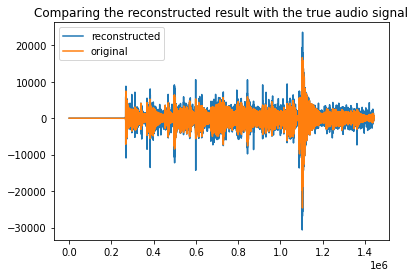

In [81]:
orig_totoro_vector = orig_totoro[1]
vec_len = orig_totoro_vector.size

x = list(range(vec_len))
plt.plot(x, reconst_totoro, label="reconstructed")
plt.plot(x, orig_totoro_vector, label="original")
plt.title("Comparing the reconstructed result with the true audio signal")
plt.legend()
plt.show()

Q. 2. d: Calculating the MSE

In [82]:
diff_vec = reconst_totoro - orig_totoro_vector
diff_elements_squared = [np.power(a, 2) for a in diff_vec]
mse = np.mean(diff_elements_squared)
print("The MSE is {mse}".format(mse=mse))

# another way to calculate, to be sure
mse = np.power(np.linalg.norm(diff_vec), 2) / vec_len
print("The MSE is {mse}".format(mse=mse))

# For comparison, we calculated the MSE between the original signal and the distorted
orig_vs_dist_diff = np.subtract(orig_totoro_vector,dist_to_fix_vec)
orig_vs_dist_mse=np.power(np.linalg.norm(orig_vs_dist_diff), 2) / vec_len
print("The MSE of orig_vs_dist is {mse}".format(mse=orig_vs_dist_mse))

# As one can see, the MSE of original+reconstructed is significantly lower than the MSE of original+distorted.
# Also, the reconstructed audio sounds quite good.
# High numbers are because of the chosen library to open WAV files.
# So in summary - we think we do not have a mistake in our implementation...

The MSE is 54417.583038473844
The MSE is 54417.583038473866
The MSE of orig_vs_dist is 2271256.1672920277
